# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab

print(df.head())

   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0


In [3]:
print(df.describe())

       temperature  heart_rate
count   130.000000  130.000000
mean     98.249231   73.761538
std       0.733183    7.062077
min      96.300000   57.000000
25%      97.800000   69.000000
50%      98.300000   74.000000
75%      98.700000   79.000000
max     100.800000   89.000000


In [31]:
# Common variables to use for this project
temps = df['temperature']
temps_len = len(temps)
temps_mean = np.mean(temps)
temps_std = np.std(temps)

## ** 1) Is the distribution of body temperatures normal? **

To test whether the data is normally distributed, I'll be using the Shapiro-Wilks Test for normality. For this, I will assume the data comes from a normally distributed population as my null hypothesis.
+ $H_{0}$: The data comes from a normally distributed population.
+ $H_{1}$: The data does not come from a normally distributed population.

Before I do so, I want to take a look at the data by graphing a histogram and ECDF.

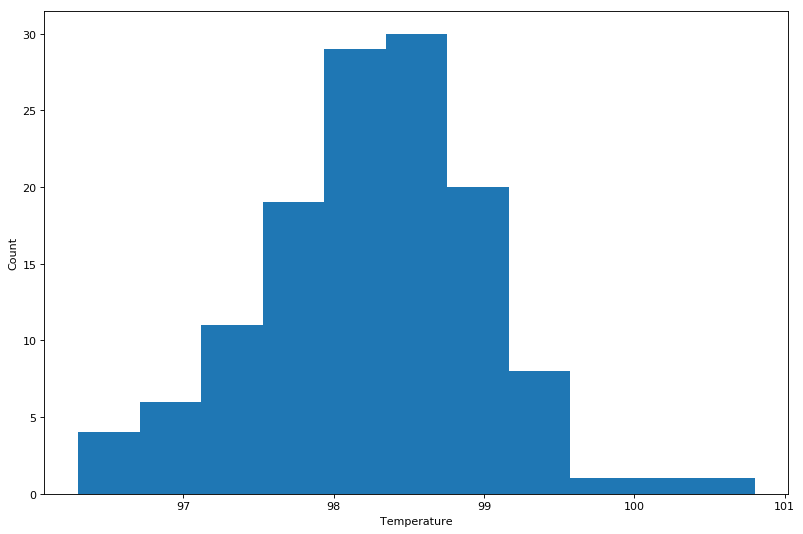

In [5]:
# Plot the histogram of temperature data
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
_ = plt.hist('temperature', data = df, bins = int(np.sqrt(130)))
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Count')

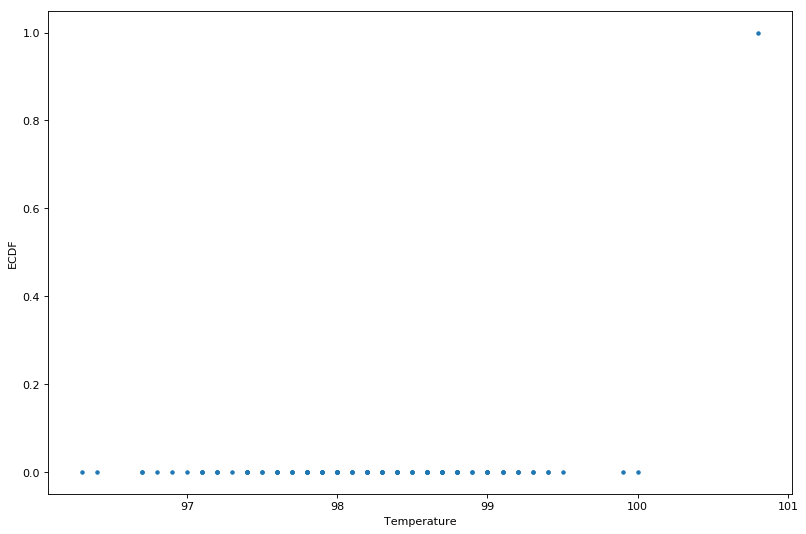

In [6]:
# Plot ECDF of temperature data
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
x = np.sort(temps)
y = np.arange(1, len(x) + 1) / len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')

Although the histogram looks like a normal distribution, with a slight right skew, I want to be sure by comparing it with the Shapiro-Wilk Test. With the Shapiro-Wilk test, I'm testing the null hypothesis that the data set is of normality with a alpha, or p-value, of 0.05. If my test statistic is 1 or close to one, that indicates normality and getting a p-value greater than our alpha, I fail to reject the null hypothesis.

In [7]:
# Get the p-value of temperature data using Shapio-Wilk test
stat, p = stats.shapiro(temps)
print(stat, p)

(0.9865770936012268, 0.233174666762352)


As shown above, I got a test statistic of 0.987 and a p-value of 0.23 which is greater than 0.05 meaning the data is approximately normal and the probability of getting that result was significant. Therefore I fail to reject the null hypothesis and therefore can't reject that the data set is normal. However, this doesn't prove normality. For that I'll have to do additional tests like a Q-Q plt.

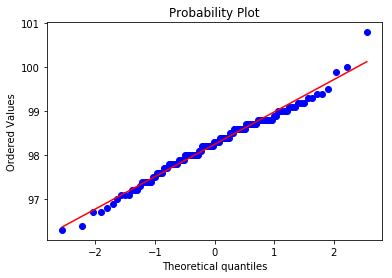

In [8]:
# Make a Q-Q plot for additional evidence for normality
stats.probplot(temps, dist='norm', plot=pylab)
pylab.show()

By looking at this plot and comparing it to the red line, the data seems to be normally distributed with a slight emphasis at the tails.

## ** 2) Is the sample size large? Are the observations independent? **

To satisfy conditions of the Central Limit Theorem, the data set must be greater than 30 observations. If we look at df.describe(), we see that there are 130 total observations. This means that this data set is large enough to to make statistical inferences on the true population. We can assume each observation is independent as well since it's well below 10% of the true population.

## ** 3) Is the true population mean really 98.6 degrees F? **

In [9]:
# Create a function that will sample data, take the mean, and store it in an array
def bs_mean(data, size=1):
    """ This function takes 'size' number of points from 'data' a 'run' number 
     of times and returns an array of means for each run """
    
    # Set the seed number
    np.random.seed(25)
    
    samples = np.empty(size)
    for i in range(size):
        sample = np.random.choice(data, len(data))
        samples[i] = np.mean(sample)
    return samples

C:\Users\Curtis\Miniconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


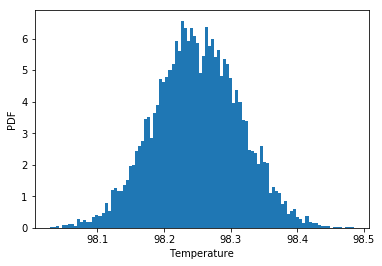

In [10]:
# Develop bootstrap sample of mean temperature data
sample_means = bs_mean(temps, size = 10000)
_ = plt.hist(sample_means, bins = 100, normed=True)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('PDF')

In [24]:
print(np.mean(sample_means))
confidence_inter = np.percentile(sample_means, [2.5, 97.5])
print(confidence_inter)

98.24952776923077
[98.12384615 98.37386538]


This distribution seems to be normalized around 98.2 degrees and 98.3 degrees with a 95% confidence interval between 98.1 degrees and 98.4 degrees. From this data set, it doesn't seem like the true population mean is 98.6 but a one-sample bootstrap hypothesis test can help confirm that.

For my hypothesis test, I propose a null hypothesis of that the mean of the data is 98.6 degrees. 
+ $H_{0}$: The true population mean temperature of the data is 98.6 degrees.
+ $H_{1}$: The true population mean temperature of the data is not 98.6 degrees.

In order to make a hypothesis test, I need to shift the data so that the mean is 98.6 degrees and come up with a test statistic and p-value. Here, the test statistic will be the difference of the shifted data from 98.6 degrees.

The observed mean difference is: -0.350769
0.0


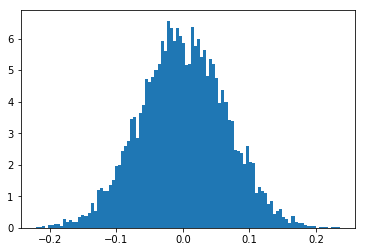

In [12]:
true_pop_mean = 98.6

# Shift the data so the mean is 98.6
temp_shifted = temps - temps_mean + true_pop_mean

# Calculate the observed difference of the mean and true population mean, 98.6
obs_mean_diff = temps_mean - true_pop_mean
print('The observed mean difference is: %f' %obs_mean_diff)

# Perform a bootstrap sample and replicate of the difference from the true population mean
bs_temp_shifted = bs_mean(temp_shifted, size=10000)
bs_temp_shifted = bs_temp_shifted - true_pop_mean

# Plot bs_temp_shifted
_ = plt.hist(bs_temp_shifted, bins = 100, normed=True)

# Calculate the p-value
p_value = np.sum(bs_temp_shifted <= obs_mean_diff)/len(bs_temp_shifted)
print(float(p_value))

Given this p-value, in 10,000 trials, not one had a difference in means less than or equal to the observed mean difference. This is significant enough to reject the null hypothesis and conclude that the true population mean temperature is not 98.6 degrees.

Other ways to test if there's a difference is to use the t/z statistics. The t-statistic would be more useful in this situation  since we don't know the true population's standard deviation.

In [13]:
# Compute the t-statistic & p-value
t_stat = (temps_mean - true_pop_mean)/(temps_std/np.sqrt(temps_len))
print(t_stat)
p_val = stats.t.sf(np.abs(t_stat), temps_len - 1) * 2
print(p_val)

-5.4759252020785585
2.1887464624050777e-07


In [14]:
np.random.seed(25)
true_pop = np.random.normal(temps_mean, size=temps_len)
true_pop_std = np.std(true_pop)

In [15]:
# Calculate the z-statistic & p-value
z_stat = (temps_mean - true_pop_mean)/(true_pop_std/np.sqrt(temps_len))
print(z_stat)
p_val_z = stats.norm.sf(np.abs(z_stat))*2
print(p_val_z)

-3.784129208702819
0.0001542476790167228


Both the t and z test produced similarly small p-values that are significant with a threshold of 0.05. However, for the z-statistic, we had to produce/simulate a normal distribution of the population to get the population's standard deviation.

## ** 4) Draw a small sample of size 10 from the data and repeat both frequentist tests. **

Here, the correct test to use is the t statistic because it works better for smaller sample sizes. A condition to use the z statistic is that the sample distribution has to be normally distributed. When the sample size is too small, the Central Limit Theorem doesn't apply and therefore isn't normal. That's why as the sample size increases, the t statistic approaches the z statistic.

In [16]:
# Draw out 10 samples from the data
np.random.seed(25)
sample_10 = np.random.choice(temps, size = 10)
sample_10_mean = np.mean(sample_10)
sample_10_std = np.std(sample_10)

In [17]:
t_stat_10 = (sample_10_mean - true_pop_mean)/(sample_10_std/np.sqrt(10))
print(t_stat_10)
pv_t_10 = stats.t.sf(np.abs(t_stat_10), 9)*2
print(pv_t_10)

-0.23138617025612185
0.8221897065992507


Again, we're going to simulate a normal distribution for the population to get the standard deviation of 10 samples from the population.

In [18]:
true_pop_10 = np.random.normal(temps_mean, size=10)
true_pop_10_std = np.std(true_pop_10)

In [19]:
z_stat_10 = (sample_10_mean - true_pop_mean)/(true_pop_10_std/np.sqrt(10))
print(z_stat_10)
pv_z_10 = stats.norm.sf(np.abs(z_stat_10))*2
print(pv_z_10)

-0.09194790168237833
0.9267394325894208


## ** 5) At what temperature should we consider someone's temperature to be "abnormal"? **

- As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
- Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

In problem 3, we took the bootstrap replicate of the mean to be 98.25 degrees. If we take a confidence interval of 95%, we can assume values outside it to be abnormal.

We can get the 95% confidence interval by getting the standard deviation of the replicate of the mean, also known as the  standard error of the mean (SEM). We then add & subtract 1.96 times the SEM to our mean to get our interval.

In [20]:
sem = temps_std/np.sqrt(temps_len)
sem

0.06405661469519337

In [23]:
print(temps_mean - 1.96*sem)
print(temps_mean + 1.96*sem)

98.12367980442816
98.37478173403333


Anything below 98.12 degrees and above 98.37 degrees is considered abnormal.

To do this with t statistics, we use the following equation:

$\bar x \pm t^*(\frac{s}{\sqrt{n}})$

where $t^*$ is the corresponding t-value for a 95% confidence interval, 1.98 in this case.

In [33]:
# Calculate upper and lower bounds of the interval
upper = temps_mean + 1.98*(temps_std/np.sqrt(temps_len))
lower = temps_mean - 1.98*(temps_std/np.sqrt(temps_len))

print(upper)
print(lower)

98.37606286632723
98.12239867213427


## ** 6) Is there a significant difference between males and females in normal temperature? **

- What testing approach did you use and why?
- Write a story with your conclusion in the context of the original problem.
    - The mean normal body temperature was held to be 37 ∘∘ C or 98.6 ∘∘ F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [36]:
# Split temperature data set into two by gender
male_temps = df[df['gender'] == 'M']['temperature']
female_temps = df[df['gender'] == 'F']['temperature']

In [38]:
# Calculate statistics of each gender
male_temps_len = len(male_temps)
male_temps_mean = np.mean(male_temps)
male_temps_std = np.std(male_temps)

female_temps_len = len(female_temps)
female_temps_mean = np.mean(female_temps)
female_temps_std = np.std(female_temps)